### **Load Environment variables from .env file**

In [1]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
from IPython.display import display, HTML, JSON, Markdown, Image

load_dotenv()
GPT4o_API_KEY = os.getenv("GPT4o_API_KEY")
GPT4o_DEPLOYMENT_ENDPOINT = os.getenv("GPT4o_DEPLOYMENT_ENDPOINT")
GPT4o_DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")


VIDEOINDEXER_ACCTID = os.getenv("VIDEOINDEXER_ACCTID")
VIDEOINDEXER_ACCTNAME = os.getenv("VIDEOINDEXER_ACCTNAME")
VIDEOINDEXER_RESOURCEGROUP = os.getenv("VIDEOINDEXER_RESOURCEGROUP")
VIDEOINDEXER_SUBSCRIPTIONID = os.getenv("VIDEOINDEXER_SUBSCRIPTIONID")


client = AzureOpenAI(
  azure_endpoint = GPT4o_DEPLOYMENT_ENDPOINT, 
  api_key=GPT4o_API_KEY,  
  api_version="2024-02-01"
)

In [2]:
def call_gpt4o_with_imgs(image_list):
    text=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video using the frames from the video provided."},
    {"role": "user", "content": [
        *map(lambda x: {"type": "image_url", 
                        "image_url": {
                            "url": f'data:image/jpg;base64,{x}', 
                            "detail": "low"}}, image_list)
        ],
    }
    ]
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

def call_gpt4o(transcript):
    text=[
        {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video transcript."},
        {"role": "user", "content": transcript}
    ]
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

In [4]:
# imports
from pprint import pprint

from VideoIndexerClient.Consts import Consts
from VideoIndexerClient.VideoIndexerClient import VideoIndexerClient


ApiVersion = '2024-01-01'
ApiEndpoint = 'https://api.videoindexer.ai'
AzureResourceManager = 'https://management.azure.com'
# create and validate consts
consts = Consts(ApiVersion, ApiEndpoint, AzureResourceManager, VIDEOINDEXER_ACCTNAME, VIDEOINDEXER_RESOURCEGROUP, VIDEOINDEXER_SUBSCRIPTIONID)

# create Video Indexer Client
vi_client = VideoIndexerClient()

# Get access tokens (arm and Video Indexer account)
vi_client.authenticate_async(consts)

In [5]:
# Do this only once, to upload and index the video
LocalVideoPath = 'data/keynote_recap.mp4'
ExcludedAI = []
file_video_id = vi_client.file_upload_async(LocalVideoPath, video_name=None, excluded_ai=ExcludedAI)
#polling for indexing status
vi_client.wait_for_index_async(file_video_id)

[Account Details] Id:4d92e8af-dd58-4550-962c-a2743eb20aa7, Location: eastus
Uploading a local file using multipart/form-data post request..
Checking if video 4kzbmvpcqb has finished indexing...
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index state is Processing
The video index has completed. Here is the full JSON of the index for video ID 4kzbmvpcqb: 
{'partition': None, 'description': None, 'privacyMode': 'Private', 'state': 'Processed', 'accountId': '4d92e8af-dd58-4550-962c-a2743eb20aa7', 'id': '4kzbmvpcqb', 'name': 'keynote_recap', 'userName': 'Denise Sch

In [6]:
# videoID un71disreu - change this to the videoID you want to get insights for
# get video insights
file_video_id = 'un71disreu'
insights = vi_client.get_video_async(file_video_id)
pprint(insights)

Searching videos in account 4d92e8af-dd58-4550-962c-a2743eb20aa7 for video ID un71disreu.
Here are the search results: 
{'partition': None, 'description': None, 'privacyMode': 'Private', 'state': 'Processed', 'accountId': '4d92e8af-dd58-4550-962c-a2743eb20aa7', 'id': 'un71disreu', 'name': 'keynote_recap', 'userName': 'Denise Schlesinger', 'created': '2024-06-16T07:50:01.28+00:00', 'isOwned': True, 'isEditable': True, 'isBase': True, 'durationInSeconds': 210, 'duration': '0:03:30.999728', 'summarizedInsights': {'name': 'keynote_recap', 'id': 'un71disreu', 'privacyMode': 'Private', 'duration': {'time': '0:03:30.999728', 'seconds': 211}, 'thumbnailVideoId': 'un71disreu', 'thumbnailId': '495e0b5a-f479-43fd-8cd4-4f72aa4d8d74', 'faces': [{'videoId': 'un71disreu', 'confidence': 0, 'description': None, 'title': None, 'thumbnailId': 'aa03dc75-117f-4b7b-b5b9-cce4699e6142', 'seenDuration': 118.1, 'seenDurationRatio': 0.5597, 'id': 1142, 'name': 'Unknown #1', 'appearances': [{'startTime': '0:00:12

In [7]:
# videoID un71disreu - change this to the videoID you want to get insights for
file_video_id = 'un71disreu'
response = vi_client.download_keyframes(file_video_id,"download/")
pprint(response)

File downloaded successfully!
None


In [8]:
# unzip the downloaded keyframes
import zipfile
with zipfile.ZipFile(f"download/{file_video_id}.zip", 'r') as zip_ref:
    zip_ref.extractall("download/keyframes")


In [9]:
import base64
import os
import time

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def encode_files(files_to_encode_path):
    base64Frames = []

    # loop through the files and encode them
    for file in os.listdir(files_to_encode_path):
        base64Frames.append(encode_image(f"{files_to_encode_path}/{file}"))
    return base64Frames


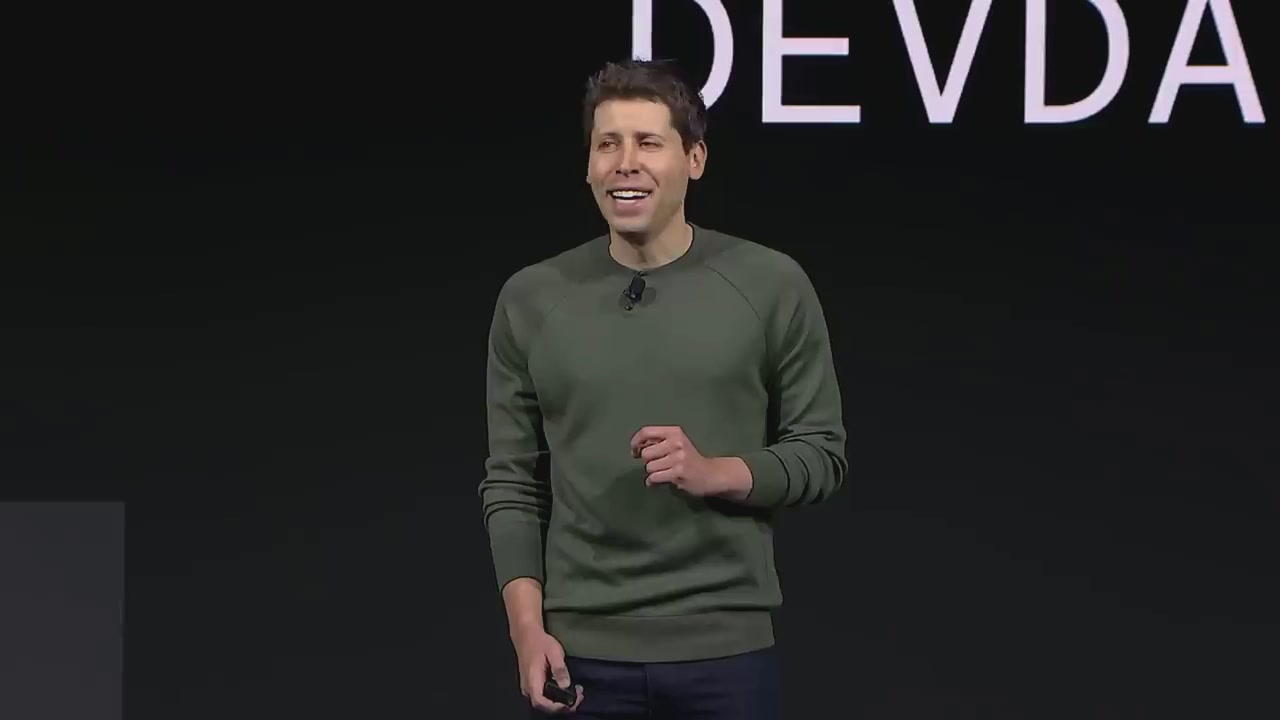

63


In [10]:
# use the keyframes generated by Azure Video Indexer to generate a summary
base64Frames = encode_files("download/keyframes")
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

print(len(base64Frames))

### Example 1: Summarization
The visual summary is generated by sending the model only the frames from the video. With just the frames, the model is likely to capture the visual aspects, but will miss any details discussed by the speaker.

In [11]:
# grab 20 frames and send them to GPT-4o for summarization
# create a loop to grab every 20 frames and send them to OpenAI for summarization from base64Frames
import copy 

nr_of_pics = len(base64Frames)
nr_of_pics_per_round = 20
start = 0
end = nr_of_pics_per_round-1
messages = []
runs = 1
accumulated_result = ""
while end < nr_of_pics:
    partial_frames = copy.deepcopy(base64Frames[start:end])
    result = call_gpt4o_with_imgs(partial_frames)
    print(f"Run {runs} - {start} to {end}")
    display(result)
    accumulated_result += result
    if nr_of_pics - end < nr_of_pics_per_round:
        break
    start = end+1
    end = start + nr_of_pics_per_round-1
    runs += 1
partial_frames = copy.deepcopy(base64Frames[end+1:nr_of_pics-1])
result = call_gpt4o_with_imgs(partial_frames)
accumulated_result += result

Run 1 - 0 to 19


'The video appears to be a summary of an event called "OpenAI DevDay." The event includes various segments and activities:\n\n1. **Event Signage**: The video starts with a shot of the "OpenAI DevDay" sign outside the venue.\n2. **Title Screens**: Several title screens with "OpenAI DevDay" are shown, setting the theme of the event.\n3. **Audience**: The venue is filled with a large audience, indicating a well-attended event.\n4. **Speakers**: Multiple shots of a speaker on stage, delivering a presentation. The speaker discusses topics such as "Custom Models," "Instructions," "Expanded Knowledge," and "Actions."\n5. **Audience Engagement**: The audience is seen clapping and engaging with the presentation.\n6. **Venue**: Shots of the venue show people mingling and the setup of the event space.\n7. **Closing**: The video ends with more title screens and the OpenAI logo, reinforcing the branding of the event.\n\nOverall, the video captures the essence of a professional and informative event

Run 2 - 20 to 39


'The video appears to be a presentation or keynote event, likely hosted by OpenAI, given the recurring logos and themes. Here is a summary based on the provided frames:\n\n1. **Event Setting**: The video starts with a view of a large audience seated in a dimly lit conference hall, indicating a significant event or presentation.\n2. **OpenAI Logo**: The OpenAI logo is displayed, setting the context for the event.\n3. **Technical Demonstration**: A frame shows a JSON snippet with a toggle switch labeled "JSON Mode: ON," suggesting a demonstration of a technical feature or capability.\n4. **GPT-4 Announcement**: A speaker on stage introduces "GPT-4," indicating a major announcement or update related to OpenAI\'s language model.\n5. **Speaker Presentation**: The speaker, whose face is blurred, is seen addressing the audience, likely explaining the features and advancements of GPT-4.\n6. **Rate Limits Interface**: A frame shows a user interface for requesting a limit increase for API usage,

Run 3 - 40 to 59


'The video appears to be a presentation at an OpenAI event, likely a developer day or similar conference. Here is a summary based on the provided frames:\n\n1. **Opening Frame**: The video starts with an animation of a cube with "OPENAI DEVDAY" written on its sides.\n2. **Introduction**: A speaker is on stage, addressing an audience.\n3. **Presentation**: The speaker, dressed in a green sweater, is giving a talk, possibly about new developments or products from OpenAI.\n4. **Key Topic - GPT-4 Turbo Pricing**: A slide shows "GPT-4 Turbo Pricing," indicating a discussion about the pricing model for GPT-4 Turbo.\n5. **OpenAI Logo**: The OpenAI logo is displayed.\n6. **Applications**: A slide shows various application icons, suggesting a discussion about different tools or features.\n7. **Animation**: An animation with a circular design is shown.\n8. **Further Presentation**: The speaker continues the presentation with "OPENAI DEVDAY" as the backdrop.\n9. **Alpha 2**: A slide with "Alpha 2

In [ ]:
final = call_gpt4o(accumulated_result)
display(final)

'### Video Summary: OpenAI DevDay Event\n\nThe video provides a comprehensive overview of the OpenAI DevDay event, capturing key moments and highlights:\n\n1. **Event Signage**: The video opens with a shot of the "OpenAI DevDay" sign outside the venue, setting the stage for the event.\n2. **Title Screens**: Various title screens display "OpenAI DevDay" in different styles and colors, reinforcing the event\'s branding.\n3. **Audience and Venue**: A large audience is shown seated in a well-lit venue, indicating a significant turnout and interest in the event.\n4. **Speaker Presentations**: Multiple frames feature a speaker on stage discussing various topics, including:\n   - **Custom Models**\n   - **Instructions**\n   - **Expanded Knowledge**\n   - **Actions**\n5. **Audience Engagement**: The audience is seen clapping and attentively listening to the presentations, highlighting their engagement and interest.\n6. **Venue Interior**: Shots of the venue\'s interior show people mingling and